In [2]:
import numpy as np
import sys
import DMDana.lib as DMDlib
import matplotlib.pyplot as plt
import numpy.linalg as LA
from DMDana.lib.constant import *
%matplotlib widget

## Load Data

Load matrix of vmat denmat ek

load other basic information

determine if denmat and vmat is hermitian

In [3]:
folder='0.00050'
vmatpath=folder+'/ldbd_data/ldbd_vmat.bin'
denmatpath=folder+'/restart/denmat_restart.bin'
Ematpath=folder+'/ldbd_data/ldbd_ek.bin'
kmesh=np.zeros(3,dtype=int)
nb,bBot_dm,bTop_dm,nk,kmesh[0],kmesh[1],kmesh[2]=DMDlib.DMDparser.read_text_from_file(
    folder+'/ldbd_data/ldbd_size.dat',
    ["# nb nv bBot_dm"]*3+["# nk_full"]*4,
    [0,2,3,1,2,3,4],
    True,
    [int]*7)
nb_dm=bTop_dm-bBot_dm
kstep=1/kmesh
def mat_init(path,shape,dtype):
    mat_raw=np.fromfile(path,dtype=dtype)
    assert len(mat_raw) == np.prod(shape), path+' size does not match expected size'
    mat=mat_raw.reshape(shape, order='C')
    return mat
def checkhermitian(mat,name):
    axessequence=np.arange(mat.ndim)
    axessequence[-2:]=axessequence[-2:][::-1]
    #print(axessequence)
    assert np.isclose(np.transpose(mat,axes=axessequence).conj(),mat,atol=1e-13,rtol=0).all(), name+' is not hermitian'
    print(name+' is hermitian')

denmat = mat_init(denmatpath,(nk, nb_dm, nb_dm),complex)
identity=np.identity(nb_dm)
Project_mat=identity[:,:,np.newaxis]*identity[:,np.newaxis,:]
diag_denmat=np.sum(Project_mat[:,np.newaxis,:,:]@denmat[np.newaxis,:,:,:]@Project_mat[:,np.newaxis,:,:],axis=0)
offdiag_denmat=denmat-diag_denmat
vmat= mat_init(vmatpath,(nk, 3, nb_dm, nb),complex)[:,:,:,bBot_dm:bTop_dm]
Emat=mat_init(Ematpath,(nk,nb),float)[:,bBot_dm:bTop_dm]
checkhermitian(denmat,'denmat')
checkhermitian(vmat,'vmat')

denmat is hermitian
vmat is hermitian


Load K vectors

In [4]:
kvecpath=folder+'/ldbd_data/ldbd_kvec.bin'
kveclist=mat_init(kvecpath,(nk,3),float)
def shift_kvec(kveclist):
    kveclist=(kveclist+0.5)%1-0.5
    return kveclist
kveclist=shift_kvec(kveclist)
kmeshlist=np.array(np.round(kveclist*kmesh),dtype=int)
kmesh_to_knum=np.full(kmesh,None)
knum=len(kmeshlist)
for knum_tmp,(i1,i2,i3) in enumerate(kmeshlist):
    kmesh_to_knum[i1,i2,i3]=knum_tmp


## Define k paths for later 2D plots

In [5]:
kpathstr='''
kpoint 0.000 0.000 0.000     Gamma
kpoint 0.000 0.500 0.500     X
kpoint 0.250 0.750 0.500     W
kpoint 0.500 0.500 0.500     L
kpoint 0.000 0.000 0.000     Gamma
kpoint 0.375 0.750 0.375     K'''

init_kpath=[]
init_Labelpath=[]
for line in kpathstr.split('\n'):
    if line:
        init_kpath.append([float(j) for j in line.split()[1:4]])
        init_Labelpath.append(line.split()[4])
init_kpath=shift_kvec(np.array(init_kpath))
kdict={}
for dir_i in range(len(init_kpath)):
    klabel=init_Labelpath[dir_i]
    kvec=init_kpath[dir_i]
    kdict[klabel]=kvec

labelpath1=['Gamma','X']
labelpath2=['L','Gamma','K']
labelpath3=['-X','Gamma','X']
labelpath4=['-K','Gamma','K']
labelpath5=['-L','Gamma','L']
kdict['-X']=-kdict['X']
kdict['-K']=-kdict['K']
kdict['-L']=-kdict['L']
kpath1=np.array([kdict[i] for i in labelpath1])
kpath2=np.array([kdict[i] for i in labelpath2])
kpath3=np.array([kdict[i] for i in labelpath3])
kpath4=np.array([kdict[i] for i in labelpath4])
kpath5=np.array([kdict[i] for i in labelpath5])

In [6]:
    
def get_mat_of_minus_k(mat):
    mat_minus_k=np.full(mat.shape,None)
    for knum_tmp in range(knum):
        minusknum_tmp=kmesh_to_knum[-kmeshlist[knum_tmp,0],-kmeshlist[knum_tmp,1],-kmeshlist[knum_tmp,2]]
        mat_minus_k[minusknum_tmp]=mat[knum_tmp]
    assert (mat_minus_k!=None).all(), 'mat_minus_k is calculated correctly, maybe some kpoints of the DMD k-list do not have minus-kpoints in the list'
    return mat_minus_k
vmat_minus_k=get_mat_of_minus_k(vmat)

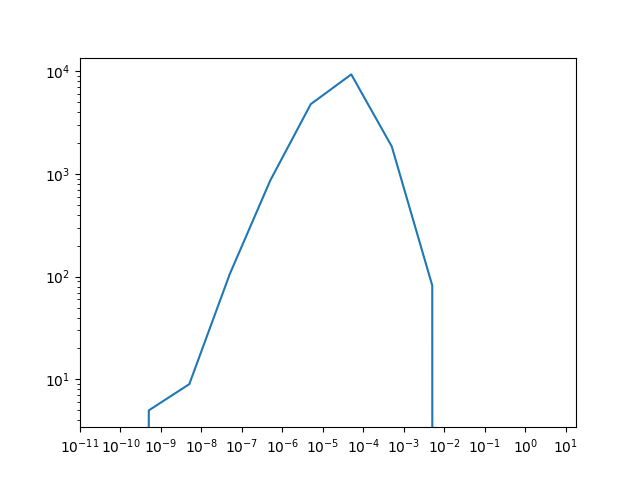

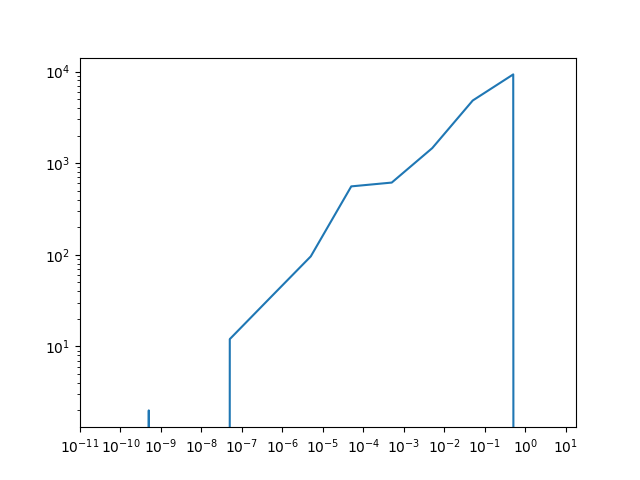

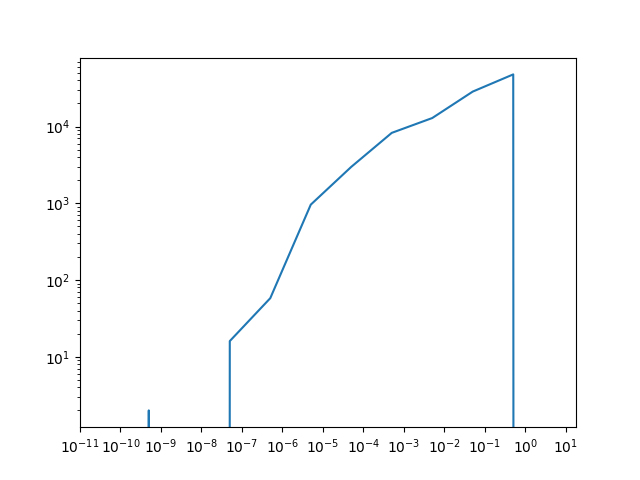

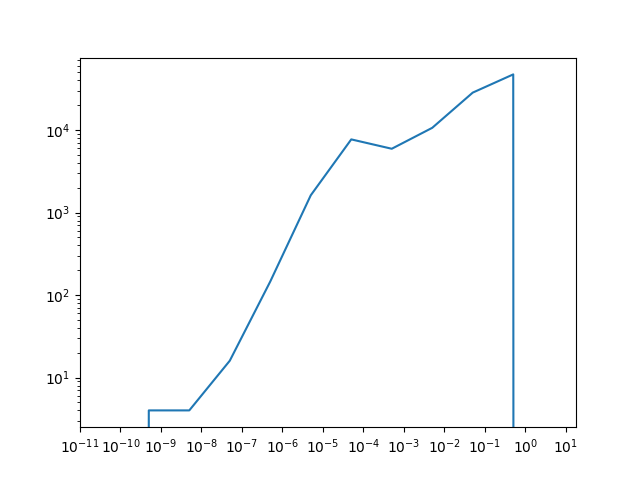

In [7]:
logbin=[10**i for i in range(-11,2)]
density=False
scal='log'
plt.figure()
hist,bins=np.histogram(np.abs(np.diagonal(vmat_minus_k+vmat,axis1=2,axis2=3)),bins=logbin,density=density)
plt.plot(bins[1:]*0.5,hist)
plt.xscale(scal)
plt.yscale(scal)
plt.xticks(logbin)
plt.show()
plt.figure()
hist,bins=np.histogram(np.abs(np.diagonal(vmat_minus_k-vmat,axis1=2,axis2=3)),bins=logbin,density=density)
plt.plot(bins[1:]*0.5,hist)
plt.xscale(scal)
plt.yscale(scal)
plt.xticks(logbin)
plt.show()
plt.figure()
hist,bins=np.histogram(np.abs(vmat_minus_k-vmat),bins=logbin,density=density)
plt.plot(bins[1:]*0.5,hist)
plt.xscale(scal)
plt.yscale(scal)
plt.xticks(logbin)
plt.show()
plt.figure()
hist,bins=np.histogram(np.abs(vmat-np.transpose(vmat_minus_k,axes=(0,1,3,2))),bins=logbin,density=density)
plt.plot(bins[1:]*0.5,hist)
plt.xscale(scal)
plt.yscale(scal)
plt.xticks(logbin)
plt.show()

## Define Plot functions

define 2D plot functions

In [8]:
from copy import deepcopy
class Plot_2D(object):
    def __init__(self,y_of_b_d_kmi:np.ndarray,color_of_b_d_kmi:np.ndarray,kpaths_pi_kpi,labelpath_pi_kpi,distance_tolerance_to_klines,seperate=True,title='',ylabel='',x_gap_between_kpaths=0.1,vmin=None,vmax=None):
        #y_of_b_d_k color_of_b_d_k should be of the same shape: (n,total_k_number)
        #d is the index of the columns, it means directions in the application of current plots
        #b is the index of the rows, it means bands in the application of current plots
        #pi is the index of the kpaths, a kpath is a list of kpoints. 
        #kp mean kpoints on k-paths
        #kpi are the index of kp 
        #There are one k-line in the k-space between one pair of the kpoints on kpaths. So one kpath consist several k-lines. The program would search for denser kpoints close to each k-lines from the kmesh of DMD.
        #km mean kpoints in k-mesh. These are the kpoints of the DMD Kmesh that are found close to each k-line. 
        #kmi are the index of km corresponding to the original kvec list of DMD data.
        #kmj are the index of km corresponding to the sequences stored in this class.
        # Note there are two K sampling concepts here: Kmesh vs Kpath.
        self.distance_of_km_to_klines=distance_tolerance_to_klines
        self.y_of_b_d_kmi=y_of_b_d_kmi
        self.color_of_b_d_kmi=color_of_b_d_kmi
        self.vmin=vmin
        self.vmax=vmax
        self.fig=plt.figure(dpi=150,figsize=(8,6))
        self.num_of_rows=y_of_b_d_kmi.shape[0]
        self.num_of_colomns=y_of_b_d_kmi.shape[1]
        self.kpaths_pi_kpi=kpaths_pi_kpi
        self.seperate=seperate
        self.axlist=[]

        if self.seperate:
            self.axlist=[[self.fig.add_subplot(self.num_of_rows,self.num_of_colomns,b*self.num_of_colomns+d+1) for d in range(self.num_of_colomns)] for b in range(self.num_of_rows)]
        else:
            self.axlist=[[self.fig.add_subplot(111)]*self.num_of_colomns]*self.num_of_rows

        for pi in range(len(self.kpaths_pi_kpi)):
            assert (self.kpaths_pi_kpi[pi])==len(labelpath_pi_kpi[pi]), 'kpath and labelpath should have the same length'
        
        template_list_pi_kpi=[[[]for kpi in range(len(pi)-1)] for pi in self.kpaths_pi_kpi]
        
        self.kmilist_of_pi_kpi_kmj=deepcopy(template_list_pi_kpi)          
        self.parallel_projection_distance_from_km_to_klines_of_pi_kpi_kmj=deepcopy(template_list_pi_kpi) 
        self.color_of_b_d_pi_kpi_kmj=[[deepcopy(template_list_pi_kpi)  for d in range(self.num_of_colomns)] for b in range(self.num_of_rows)]
        self.xlabel_of_allpaths_pi_kpi=[]
        self.x_of_allpaths_of_pi_kpi=[]
    
        largest_x_of_last_path=0
        for pi in range(len(kpaths_pi_kpi)):
            kpath_kpi=self.kpaths_pi_kpi[pi]
            Labelpath_kpi=labelpath_pi_kpi[pi]
            kpathshift_kpi=np.roll(kpath_kpi,1,axis=0)
            kpathshift_kpi[0,:]=kpath_kpi[0]
            len_kpath_kpi=LA.norm(kpath_kpi-kpathshift_kpi,axis=1)
            len_kpath_sum_kpi=np.cumsum(len_kpath_kpi)
            self.x_of_allpaths_of_pi_kpi.append(len_kpath_sum_kpi+largest_x_of_last_path)
            self.xlabel_of_allpaths_pi_kpi.append(Labelpath_kpi)
            largest_x_of_last_path+=len_kpath_sum_kpi[-1]+x_gap_between_kpaths

        self.get_kmi_and_parallel_projection_distance()
        max_color, min_color=self.get_color_range()
        colorbartmp = self.plot(max_color, min_color)
        self.postprocess(title, ylabel, colorbartmp)
   
    def get_kmi_and_parallel_projection_distance(self):
        for pi,kpath in enumerate(self.kpaths_pi_kpi):
            for kpi in range(len(kpath)-1):
                k1=kpath[kpi]
                k2=kpath[kpi+1]
                kmi,parallel_projection_distance_from_km_to_klines=self.get_km_near_kline(k1,k2,self.distance_of_km_to_klines)
                self.kmilist_of_pi_kpi_kmj[pi][kpi].append(kmi)
                self.parallel_projection_distance_from_km_to_klines_of_pi_kpi_kmj[pi][kpi].append(parallel_projection_distance_from_km_to_klines)
    def get_color_range(self):
        for b in range(self.num_of_rows):
            for d in range(self.num_of_colomns):
                for pi,kpath in enumerate(self.kpaths_pi_kpi):
                    for kpi in range(len(kpath)-1):
                        self.color_of_b_d_pi_kpi_kmj[b][d][pi][kpi].append(self.color_of_b_d_kmi[b][d][self.kmilist_of_pi_kpi_kmj[pi][kpi]])
        max_color=np.max(np.abs(np.array(self.color_of_b_d_pi_kpi_kmj))) if self.vmin is None else self.vmax
        min_color=-np.max(np.abs(np.array(self.color_of_b_d_pi_kpi_kmj))) if self.vmin is None else self.vmin
        return max_color,min_color
    def plot(self, max_color, min_color):
        for b in range(self.num_of_rows):
            for d in range(self.num_of_colomns):
                ax=self.axlist[-b-1][d]
                for pi,kpath in enumerate(self.kpaths_pi_kpi):
                    for kpi,kpath in enumerate(self.kpaths_pi_kpi):
                        #print(path_i,func_i,k_i)
                        kmilist_of_kmj=self.kmilist_of_pi_kpi_kmj[pi][kpi]
                        color=self.color_of_b_d_pi_kpi_kmj[b][d][pi][kpi]
                        dis_on_line_of_kmj=self.parallel_projection_distance_from_km_to_klines_of_pi_kpi_kmj[b][d][pi][kpi]
                        #print(dis_on_line)
                        colorbartmp=ax.scatter(self.x_of_allpaths_of_pi_kpi[pi][kpi]+dis_on_line_of_kmj,self.y_of_b_d_kmi[b][d][kmilist_of_kmj],c=color\
                                    ,s=5,vmin=min_color,vmax=max_color,cmap='rainbow')
        return colorbartmp
    def postprocess(self, title, ylabel, colorbartmp):
        if self.seperate:
            for b in range(self.num_of_rows):
                for d in range(self.num_of_colomns):
                    ax=self.axlist[-b-1][d]
                    ax.set_xlim(0,self.x_of_allpaths_of_pi_kpi[-1])
                    ax.set_xticks(self.x_of_allpaths_of_pi_kpi,[])
            for d in range(self.num_of_colomns):
                self.axlist[-1][d].set_xlabel('kpath')
                self.axlist[-1][d].set_xticks(self.x_of_allpaths_of_pi_kpi,self.xlabel_of_allpaths_pi_kpi)      
        else:
            ax=self.axlist[0][0]
            ax.set_xlim(0,self.x_of_allpaths_of_pi_kpi[-1])
            ax.set_xticks(self.x_of_allpaths_of_pi_kpi,[])
            
        self.fig.subplots_adjust(right=0.8)
        cbar_ax = self.fig.add_axes([0.85, 0.15, 0.05, 0.7])
        self.fig.colorbar(colorbartmp, cax=cbar_ax)
        self.fig.suptitle(title)
        self.fig.supylabel(ylabel)

    def get_km_near_kline(self,k1,k2,distance):
        kvec_of_line=k2-k1
        kveclist_minus_k1=kveclist-k1
        kvec_of_line_norm=LA.norm(kvec_of_line)
        dis_paral=np.einsum('kd,d->k',kveclist_minus_k1,kvec_of_line)/kvec_of_line_norm
        kveclist_project_paral=np.einsum('k,d->kd',dis_paral,kvec_of_line)/kvec_of_line_norm
        kveclist_projct_perp=kveclist_minus_k1-kveclist_project_paral
        dis_perp=LA.norm(kveclist_projct_perp,axis=1)
        in_paral_range=np.logical_and(0<=dis_paral,dis_paral<=LA.norm(kvec_of_line))
        in_perp_range=dis_perp<=distance
        final_range=np.logical_and(in_paral_range,in_perp_range)
        knum_list=np.arange(len(kveclist))[final_range]
        return knum_list,dis_paral[final_range]


define 3D plot functions

In [9]:
def plot3D(func_list_of_k,vmin=None,vmax=None,title='',rownum=1,index_str_for_title='i'):
    #init
    fig=plt.figure()
    num_of_func=len(func_list_of_k)
    columnnum=num_of_func//rownum+1 if num_of_func%rownum!=0 else num_of_func//rownum
    #j=columnnum if i%columnnum==0 else i%columnnum
    #i=int((i-j)/columnnum+1)
    axlist = [fig.add_subplot(rownum,columnnum,i,projection='3d') for i in range(1,num_of_func+1)]

    colormax=np.max(np.abs(func_list_of_k)) if vmax is None else vmax
    colormin=-np.max(np.abs(func_list_of_k)) if vmin is None else vmin
    #plot
    for func_i,func_of_k in enumerate(func_list_of_k):
        ax=axlist[func_i]
        tmp=ax.scatter(kveclist[:,0],kveclist[:,1],kveclist[:,2],c=func_of_k,s=5,cmap='rainbow',vmin=colormin,vmax=colormax)
        #ax.set_xlim(-0.5,0.5)
        #ax.set_ylim(-0.5,0.5)
        #ax.set_zlim(-0.5,0.5)
        
    #postprocess
    for ax_i,ax in enumerate(axlist):
        ax.set_xlabel('kx')
        ax.set_ylabel('ky')
        ax.set_zlabel('kz')
        ax.set_title('%s %d'%(index_str_for_title,ax_i))
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(tmp, cax=cbar_ax)
    fig.suptitle(title)


## Plot Occupation

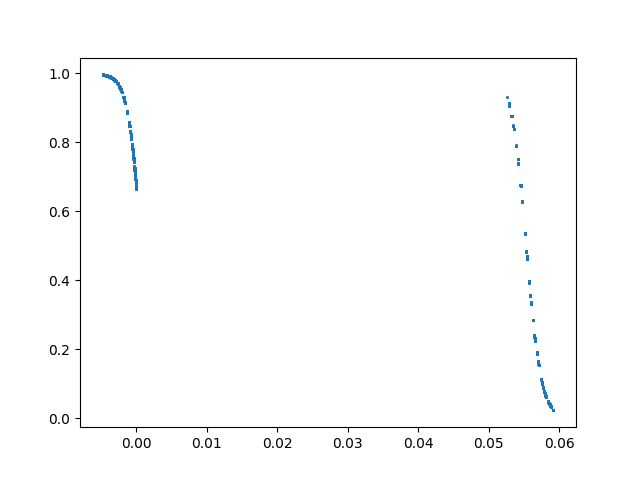

In [10]:
plt.figure()
occup_mat=np.real(np.einsum('kbb->kb',denmat))
plt.scatter(Emat.flatten(),occup_mat.flatten(),s=1)
plt.show()

## Plot Bandstructure

In [11]:
bandmat=np.zeros((nb_dm,len(kveclist)))
bandmat+=np.arange(nb_dm)[:,np.newaxis]

2D

AttributeError: 'list' object has no attribute 'shape'

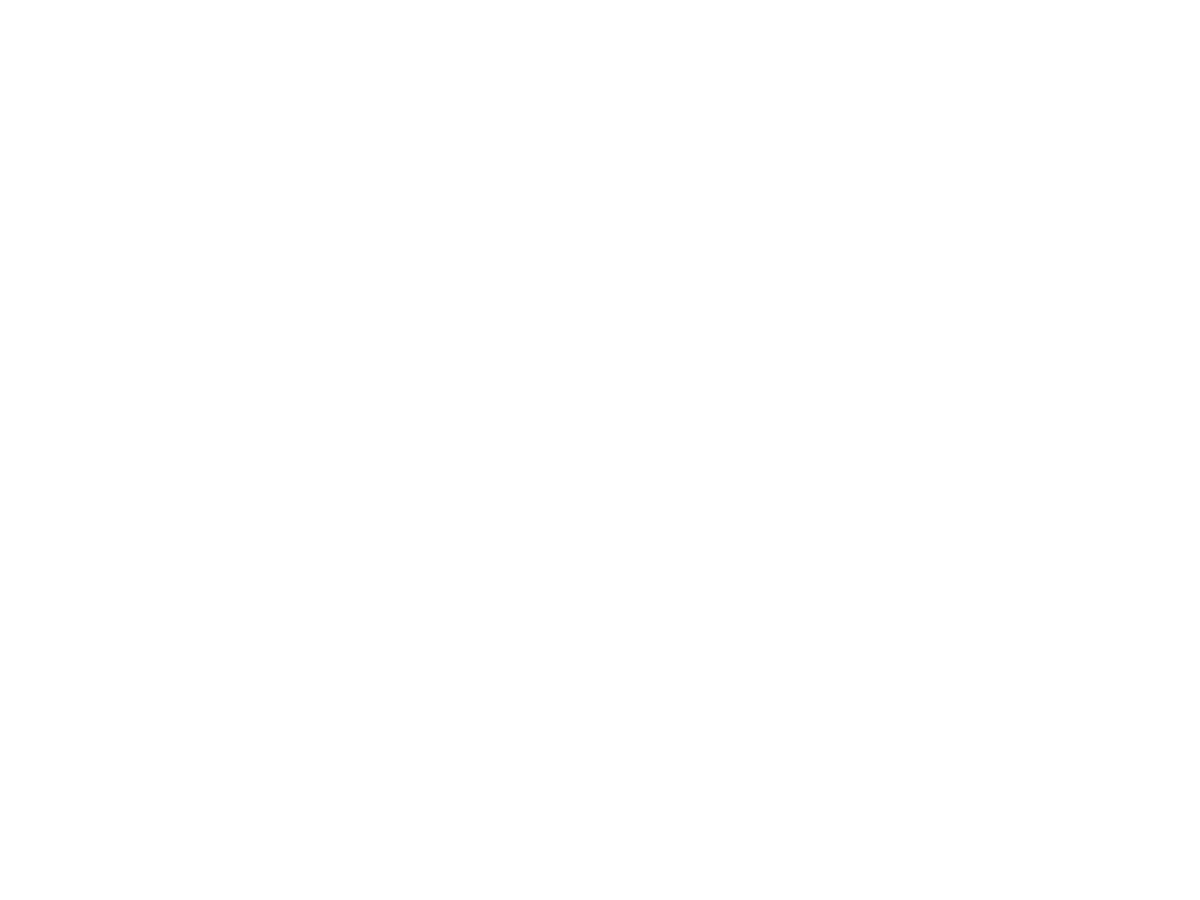

In [12]:
kpathlist=[kpath1,kpath2]
labelpathlist=[labelpath1,labelpath2]
Plot_2D([Emat.T*Hatree_to_eV],[bandmat],kpathlist,labelpathlist,LA.norm(kstep),True,x_gap_between_kpaths=0.1,vmin=0,vmax=nb_dm)

3D

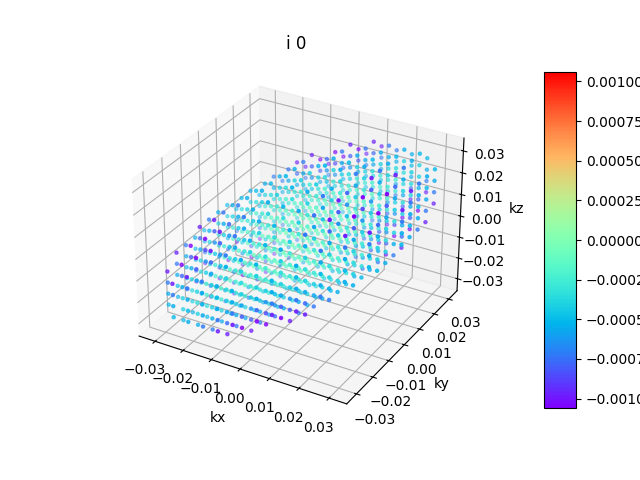

In [ ]:
plot3D([Emat[:,3]])

## Plot Current

In [ ]:
vmat_tmp=np.transpose(vmat,(1,0,2,3))
offdiag_current_d_k_b=np.diagonal(offdiag_denmat@vmat_tmp,axis1=2,axis2=3)
diag_current_d_k_b=np.diagonal(diag_denmat@vmat_tmp,axis1=2,axis2=3)
tot_current_d_k_b=np.diagonal(denmat@vmat_tmp,axis1=2,axis2=3)
offdiag_current_d_k=np.sum(offdiag_current_d_k_b,axis=2)
diag_current_d_k=np.sum(diag_current_d_k_b,axis=2)
tot_current_d_k=np.sum(tot_current_d_k_b,axis=2)

2D

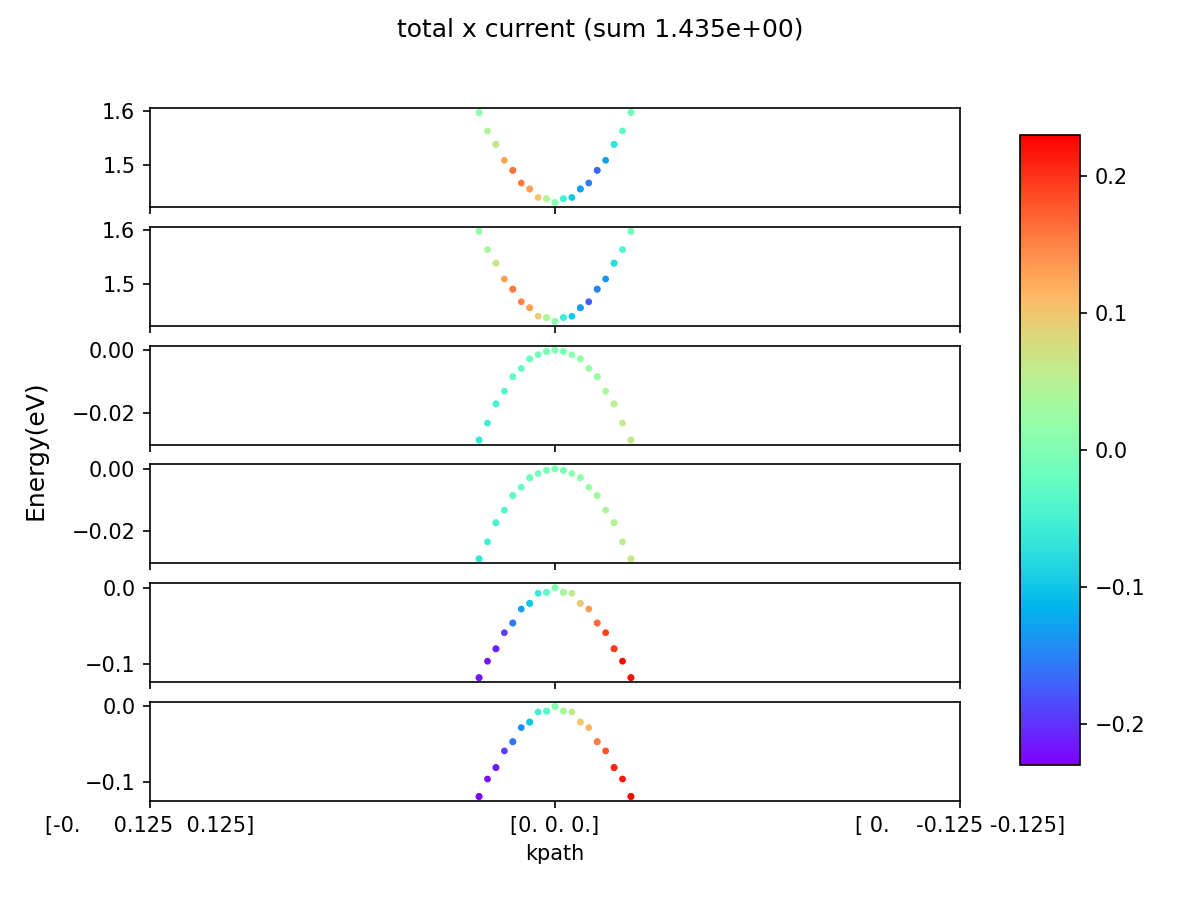

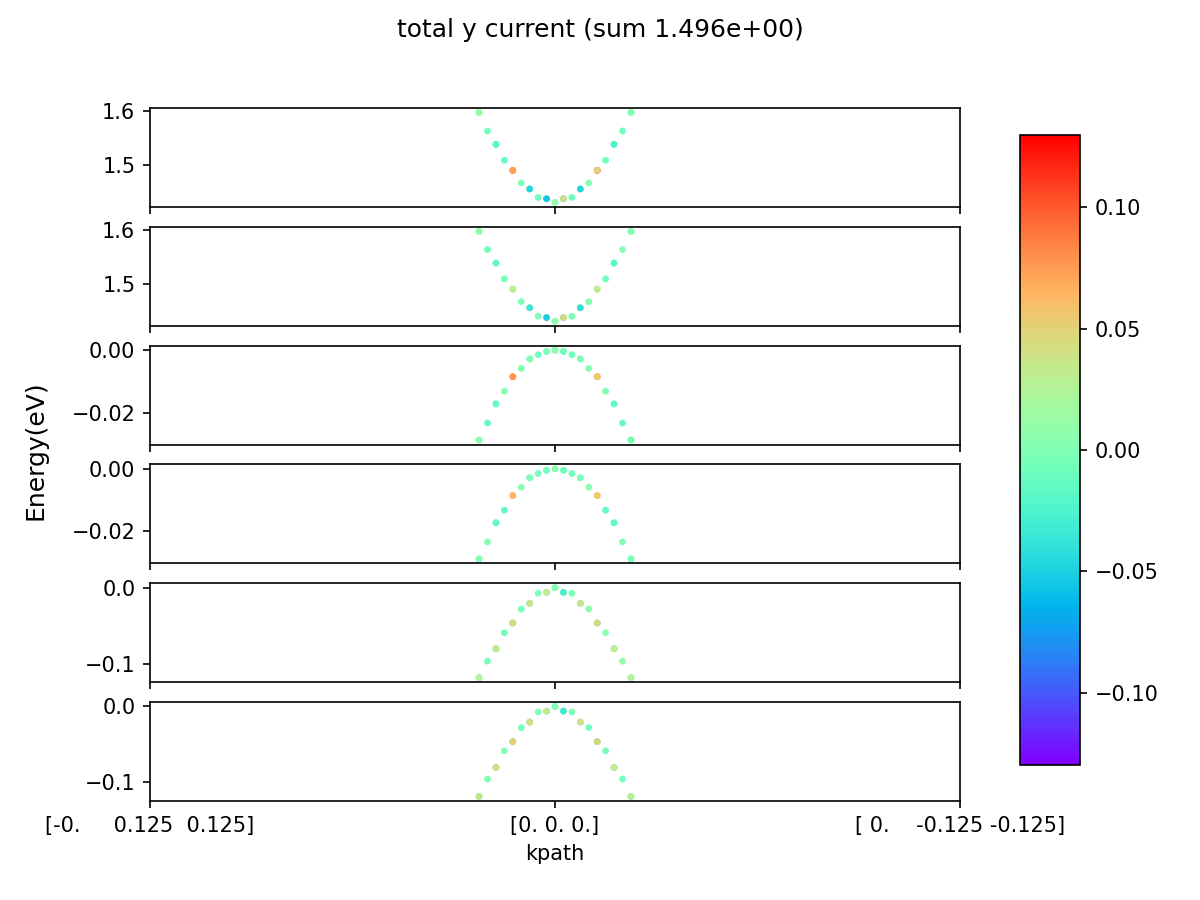

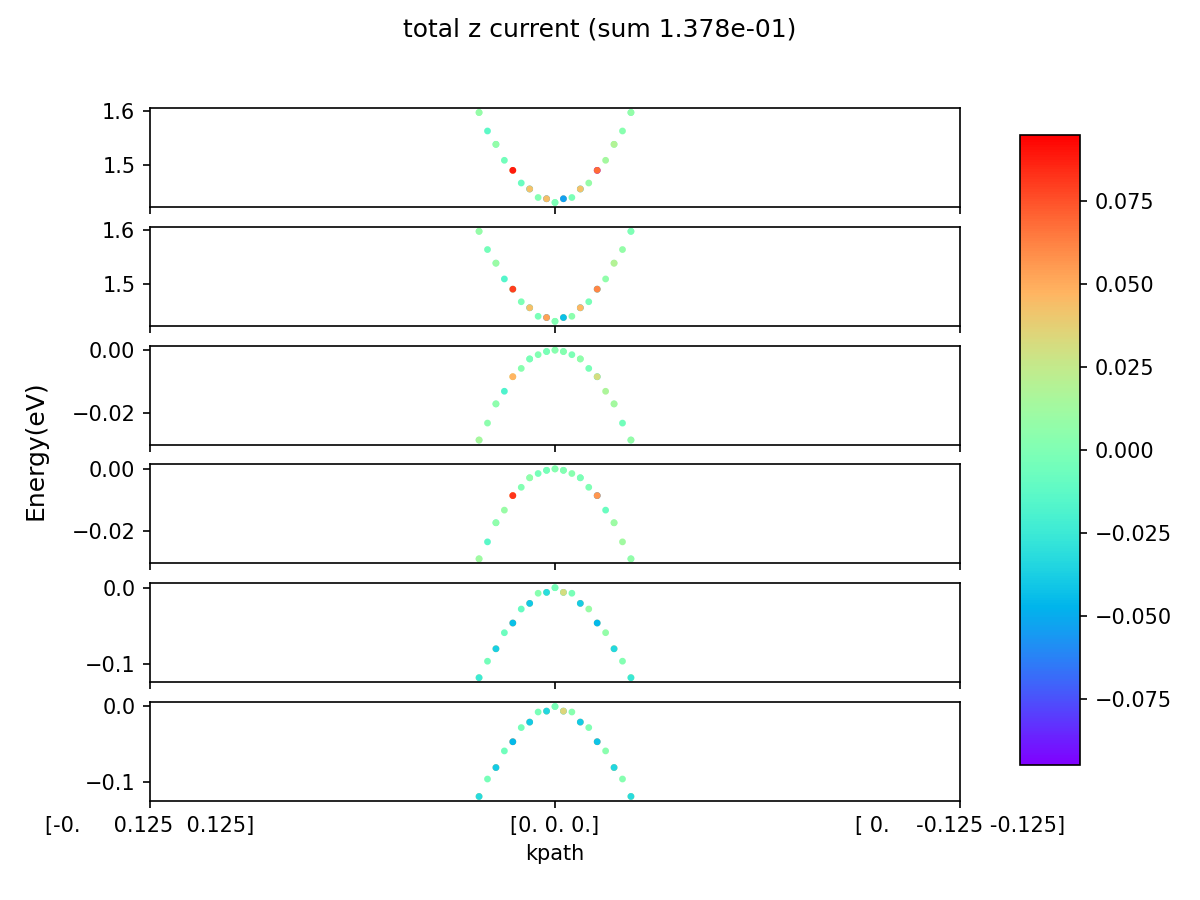

In [ ]:
current_name='total'
kpathlist=[[-kdict['X']/4,kdict['Gamma'],kdict['X']/4]]
labelpathlist=kpathlist
if current_name=='total':
    current_to_plot=tot_current_d_k_b
elif current_name=='diag':
    current_to_plot=diag_current_d_k_b
elif current_name=='offdiag':
    current_to_plot=offdiag_current_d_k_b
direction_label=['x','y','z']
for dir_i in range(3):
    sum=np.real(np.sum(current_to_plot[dir_i]))
    Plot_2D(Emat.T*Hatree_to_eV,current_to_plot[dir_i,:,:].real.T,kpathlist,labelpathlist,LA.norm(kstep)/2,title='%s %s current (sum %.3e)'%(current_name,direction_label[dir_i],sum),ylabel='Energy(eV)')


3D

/software/zbai29/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/software/zbai29/miniconda3/lib/python3.11/site-packages/matplotlib/axes/_axes.py:4455: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


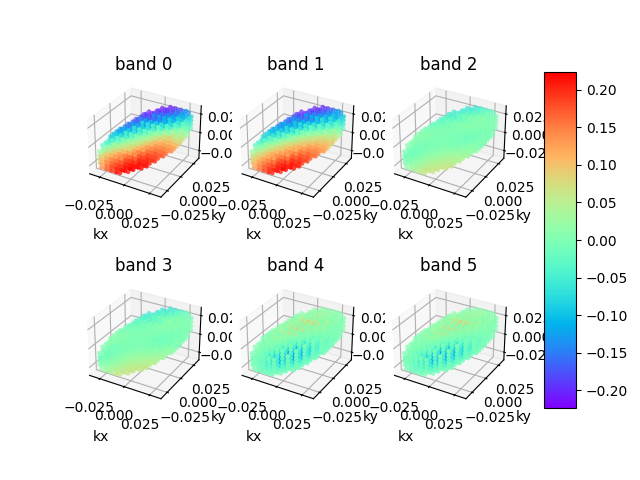

In [ ]:
current_to_plot=diag_current_d_k_b
dir_i=0
plot3D(current_to_plot[dir_i].T,rownum=2,index_str_for_title='band')
